# Tropical cyclone detection using TempestExtremes  
The recipe detects and track tropical cyclones using TempestExtremes. Tropical cyclones are identified from mean sea level pressure (MSLP) minima with compact MSLP contours and warm-core structure.

**References:**  
Ullrich, P.A., C.M. Zarzycki, E.E. McClenny, M.C. Pinheiro, A.M. Stansfield and K.A. Reed (2021) "TempestExtremes v2.1: A community framework for feature detection, tracking and analysis in large datasets" Geosci. Model. Dev. 14, pp. 5023–5048. [https://gmd.copernicus.org/articles/14/5023/2021/]

Ullrich, P.A. and C.M. Zarzycki (2017) "TempestExtremes v1.0: A framework for scale-insensitive pointwise feature tracking on unstructured grids" Geosci. Model. Dev. 10, pp. 1069-1090. [https://gmd.copernicus.org/articles/10/1069/2017/]

Zarzycki, C.M. and P.A. Ullrich (2017) "Assessing sensitivities in algorithmic detection of tropical cyclones in climate data" Geophys. Res. Lett. 44 (2), pp. 1141-1149. [https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2016GL071606]

<span style="color: mediumblue;">Load python packages</span>

In [1]:
from datetime import datetime, timedelta
import xarray as xr
import pandas as pd
import numpy as np
import sys
import os

<span style="color: mediumblue;">Set and load the paths for WxSysLib installed on your local directory (⚠️ you will need to `git clone` the entire WxSysLib to your own directory first)</span>

In [2]:
os.environ['WXSYSLIBDIR']='/g/data/gb02/cj0591/WxSysLib' # ⚠️ change to where your WxSysLib is placed
sys.path.append(os.environ['WXSYSLIBDIR'])

<span style="color: mediumblue;">Set and load the path for TempestExtremes on `gb02/public/tools/Wx`</span>

In [3]:
os.environ['TEMPESTEXTREMESDIR']='/g/data/gb02/public/tools/Wx/tempestextremes/bin' # ⚠️ don't change directory here

<span style="color: mediumblue;">TempestExtremes allows running using mpi</span>

In [4]:
from dask.distributed import Client
client = Client(n_workers=2)

<span style="color: mediumblue;">load tempestextremes utils</span>

In [5]:
from utils.nodes.tempestextremes_utils.node_utils import (
run_detectNodes,
run_stitchNodes,
run_nodeCompose,
create_Node_dirstruct,
assign_lev)

<span style="color: mediumblue;">load other utils from WxSysLib</span>

In [6]:
from utils.general.nci_utils import get_GADI_ERA5_filename
from utils.general.date_utils import generate_datetimes_months
from utils.general.file_utils import write_to_filelist
from utils.plotting.node_plotting import plot_node_tracks

<span style="color: mediumblue;">Create required directories using `create_Node_dirstruct`</span>  

In [9]:
work_dir = '/scratch/if69/cj0591' # ⚠️ change to your own directory
casename = 'tc_example'
dirs = create_Node_dirstruct(work_dir, casename)
casepath = dirs[0]

Directory '/scratch/if69/cj0591/tc_example' already exists.
Directory '/scratch/if69/cj0591/tc_example/input' already exists.
Directory '/scratch/if69/cj0591/tc_example/detectNodes' already exists.
Directory '/scratch/if69/cj0591/tc_example/stitchNodes' already exists.
Directory '/scratch/if69/cj0591/tc_example/nodeFileCompose' already exists.
Directory '/scratch/if69/cj0591/tc_example/logs' already exists.


<span style="color: mediumblue;">Let's detect and track tropical cyclones for two-month ERA5 data</span>

In [10]:
std_month = datetime(2023,1,1)
end_month = datetime(2023,2,1)
months_list = generate_datetimes_months(std_month,end_month)
date_id = [dt.strftime('%Y%m') for dt in months_list]

## <span style="color: mediumblue;">Create input filelist and output filelist</span>  

The following variables are required for tropical cyclone detection and tracking.

| Variable Name                 | Level                             |
|-------------------------------|-----------------------------------|
| Elevation (zs)                | Surface                           |
| 10-m U-component Wind (u10)   | Surface                           |
| 10-m V-component Wind (v10)   | Surface                           |
| Mean Sea Level Pressure (msl) | Surface                           |
| Geopotential (z)              | 500 hPa, 300 hPa                  |   

In [11]:
# input filelist 
input_filelist  =f'{casepath}/input/input_files.txt'
data_filenames = []
for m in months_list:
    zsfile   = '/g/data/if69/cj0591/WxSysLib/test_data/zs_era5_oper_sfc_invariant.nc'
    zfile    = get_GADI_ERA5_filename('z',  m,stream='hourly',level_type='pressure-levels')
    mslfile  = get_GADI_ERA5_filename('msl',m,stream='hourly',level_type=  'single-levels') 
    u10file  = get_GADI_ERA5_filename('10u',m,stream='hourly',level_type=  'single-levels') 
    v10file  = get_GADI_ERA5_filename('10v',m,stream='hourly',level_type=  'single-levels')
    data_filenames.append(f"{zfile};{zsfile};{mslfile};{u10file};{v10file}")
write_to_filelist(data_filenames,input_filelist)

<span style="color: mediumblue;">An input filelist contains a list of required ERA5 variable filenames separateed by semicolon</span>

In [12]:
!cat $input_filelist

/g/data/rt52/era5/pressure-levels/reanalysis/z/2023/z_era5_oper_pl_20230101-20230131.nc;/g/data/if69/cj0591/WxSysLib/test_data/zs_era5_oper_sfc_invariant.nc;/g/data/rt52/era5/single-levels/reanalysis/msl/2023/msl_era5_oper_sfc_20230101-20230131.nc;/g/data/rt52/era5/single-levels/reanalysis/10u/2023/10u_era5_oper_sfc_20230101-20230131.nc;/g/data/rt52/era5/single-levels/reanalysis/10v/2023/10v_era5_oper_sfc_20230101-20230131.nc
/g/data/rt52/era5/pressure-levels/reanalysis/z/2023/z_era5_oper_pl_20230201-20230228.nc;/g/data/if69/cj0591/WxSysLib/test_data/zs_era5_oper_sfc_invariant.nc;/g/data/rt52/era5/single-levels/reanalysis/msl/2023/msl_era5_oper_sfc_20230201-20230228.nc;/g/data/rt52/era5/single-levels/reanalysis/10u/2023/10u_era5_oper_sfc_20230201-20230228.nc;/g/data/rt52/era5/single-levels/reanalysis/10v/2023/10v_era5_oper_sfc_20230201-20230228.nc


<span style="color: mediumblue;">An output filelist contains a list of detected nodes</span>

In [13]:
# output filelist
detect_filelist =f'{casepath}/input/output_files.txt'
detect_filenames = [f"{casepath}/detectNodes/detectNodes_{dt}.txt" for dt in date_id]
write_to_filelist(detect_filenames,detect_filelist)

!cat $detect_filelist

/scratch/if69/cj0591/tc_example/detectNodes/detectNodes_202301.txt
/scratch/if69/cj0591/tc_example/detectNodes/detectNodes_202302.txt


## <span style="color: mediumblue;">Run detectNode:</span>   
`run_detectNodes` is a tool to detect nodes (points) with specific thresholds

`searchby='min'` and `detect_var='msl` - search for msl minimum  

`merge_dist=6.0` - merge two detected nodes if they are to closed to each other (6.0 great circle distance)  

`bounds=[100, 240, -60, 0]` - a box (lon_min, lon_max, lat_min, lat_max) for where cyclones are identified  

**tc_contour_command**   


`msl,200.0,5.5,0` - change in msl within 5.5 GCD from the centre is greater than 200 Pa

`_DIFF(z(300millibars),z(500millibars)),-58.8,6.5,1.0` - the difference between Z300 and Z500 must decrease by 58.8 m^2/s^2 over a 6.5 GCD, using the maximum value of thie field within 1 GCD as reference. The command ensures a coherent upper-level warm core attached to detected surface msl minimum. 



**tc_output_command**    

`msl,min,0` - output the mimum msl at the detected node   

`_VECMAG(u10,v10),max,2.0` - output the maximum magnitude of 10-m wind within 2.0 GCD of the detected node.  

`zs,min,0` - output the surface height (elevation) at the detected node

In [14]:
tc_contour_command = (
    'msl,200.0,5.5,0;'
    '_DIFF(z(300millibars),z(500millibars)),-58.8,6.5,1.0'
)

tc_output_command  = (
    'msl,min,0;'
    '_VECMAG(u10,v10),max,2.0;'
    'zs,min,0'
)

run_detectNodes(input_filelist,
                detect_filelist,
                mpi_np=2,
                searchby='min',
                detect_var='msl',
                merge_dist=6.0,
                bounds=[100, 240, -60, 0],
                closedcontour_commands=tc_contour_command,
                output_commands=tc_output_command,
                timeinterval='6hr',
                lonname='longitude',
                latname='latitude',
                logdir=f'{casepath}/logs',
                regional=True,
                quiet=True,
                out_command_only=False
)

mpirun -np 2 /g/data/gb02/public/tools/Wx/tempestextremes/bin/DetectNodes --in_data_list /scratch/if69/cj0591/tc_example/input/input_files.txt --out_file_list /scratch/if69/cj0591/tc_example/input/output_files.txt --searchbymin "msl" --closedcontourcmd "msl,200.0,5.5,0;_DIFF(z(300millibars),z(500millibars)),-58.8,6.5,1.0" --mergedist 6.0 --outputcmd "msl,min,0;_VECMAG(u10,v10),max,2.0;zs,min,0" --timefilter "6hr" --latname latitude --lonname longitude --logdir /scratch/if69/cj0591/tc_example/logs --regional --minlon 100 --maxlon 240 --minlat -60 --maxlat 0
Running command ...


## <span style="color: mediumblue;">Run stitch Node:</span>  
`run_stitchNodes` is a tool to connect detected nodes in time

`output_filefmt="csv"` - format of the stitchNode output

`in_fmt_commands="lon,lat,msl,wind,zs"` - column names of input detectNode file  

`range_dist=8.0` - the maximum distance (in GCD) that a node can move between subsequent detections. 

`minim_time="54h"` - the minimum persistence time of each trajectory (from genesis to termination). 

`maxgap_time="24h"` - the maximum duration between two sequential detections


**tc_stitch_threshold_command**   


`wind,>=,10.0,10` - the wind magnitude must be greater than 10 m/s for 10 time steps.   

`lat,<=,50.0,10;lat,>=,-50.0,10` - the latitude must be between 50S and 50N for 10 time steps. 

`zs,<,150.0,10` - the detected node must be below 150 m for 10 time steps 

In [15]:
stitch_file = f'{casepath}/stitchNodes/stitchNodes_output.csv'

tc_stitch_threshold_command  = (
    'wind,>=,10.0,10;'
    'lat,<=,50.0,10;lat,>=,-50.0,10;'
    'zs,<,150.0,10'
)

run_stitchNodes(detect_filelist,
                stitch_file,
                mpi_np=1,
                output_filefmt="csv",
                in_fmt_commands="lon,lat,msl,wind,zs",
                range_dist=8.0,
                minim_time="54h",
                maxgap_time="24h",
                min_endpoint_dist=12.0,
                threshold_condition=tc_stitch_threshold_command,
                quiet=True,
                out_command_only=False)

mpirun -np 1 /g/data/gb02/public/tools/Wx/tempestextremes/bin/StitchNodes --in_list /scratch/if69/cj0591/tc_example/input/output_files.txt --in_fmt lon,lat,msl,wind,zs --range 8.0 --mintime 54h --maxgap 24h --threshold wind,>=,10.0,10;lat,<=,50.0,10;lat,>=,-50.0,10;zs,<,150.0,10 --min_endpoint_dist 12.0 --out_file_format csv --out /scratch/if69/cj0591/tc_example/stitchNodes/stitchNodes_output.csv


<span style="color: mediumblue;">Let's have a look at detected tropical cyclones using `plot_node_tracks` function</span>.  

In [16]:
stitch_file = f'{casepath}/stitchNodes/stitchNodes_output.csv'
df = pd.read_csv(stitch_file, skipinitialspace=True)

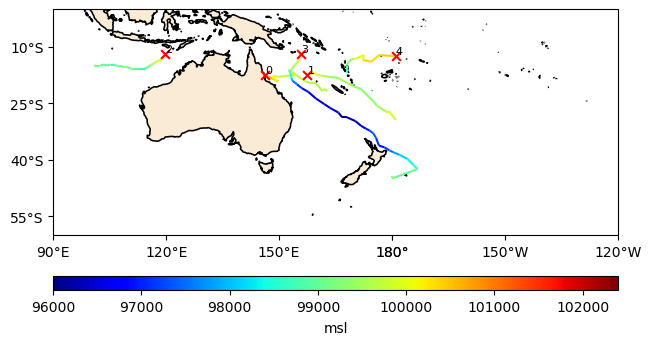

In [17]:
fig = plot_node_tracks(df,'msl', 960_00, 1024_00, 90, 240, -60, 0, 'jet')

## <span style="color: mediumblue;">Run nodeCompose:</span>   
`run_nodeCompose` is a tool to extract fields centred at nodes along their tracks.

`level_type='pressure-levels'` - level types of ERA5 data (single-levels, pressure-levels, potential-temperature)

`grid_type='XY'` - grid type as Cartesian stereographic projection with eastwards X coordinate vector and northwards Y coordinate vector. Grid spacing is equidistant.

`variables=['u', 'v']` - list for variables that will be extracted. 

`dx=0.5` - horizontal grid spacing 

`resx=21` - number of grid cells in each coordinate direction

In [18]:
snap_file = f'{casepath}/nodeFileCompose/snap_exmaple.nc'
run_nodeCompose(stitch_file,
                snap_file,
                in_fmt='(auto)',
                level_type='single-levels',
                grid_type='XY',
                variables=['msl'],
                lonname="longitude",
                latname="latitude",
                dx=0.5, resx=41,
                quiet=True,
                out_command_only=False)

/g/data/gb02/public/tools/Wx/tempestextremes/bin/NodeFileCompose --in_nodefile /scratch/if69/cj0591/tc_example/stitchNodes/stitchNodes_output.csv --in_nodefile_type SN --in_fmt (auto) --snapshots --in_data_list /scratch/gb02/cj0591/tc_example/nodeFileCompose/inputlist.txt --dx 0.5 --resx 41 --out_grid XY --out_data /scratch/gb02/cj0591/tc_example/nodeFileCompose/snap_exmaple.nc --latname latitude --lonname longitude --var msl --varout msl


<span style="color: mediumblue;">⚠️Node the extract fields do not have vertical coordinate. `assign_lev` is used to assign vertical coordiante, if needed</span>

In [19]:
ds = xr.open_dataset(snap_file)

`snap_pathid` - track id for each trajectory. 

`snap_time`, `snap_lon` and `snap_lat` - time, longitude, and latitude of each node.  

`snap_msl` - extract variables at each detected node.  

In [20]:
ds

<xarray.Dataset> Size: 710kB
Dimensions:      (x: 41, y: 41, snapshot: 104)
Coordinates:
  * x            (x) float64 328B -10.0 -9.5 -9.0 -8.5 -8.0 ... 8.5 9.0 9.5 10.0
  * y            (y) float64 328B -10.0 -9.5 -9.0 -8.5 -8.0 ... 8.5 9.0 9.5 10.0
Dimensions without coordinates: snapshot
Data variables:
    snap_pathid  (snapshot) int32 416B ...
    snap_lon     (snapshot) float64 832B ...
    snap_lat     (snapshot) float64 832B ...
    snap_time    (snapshot) datetime64[ns] 832B ...
    snap_msl     (snapshot, y, x) float32 699kB ...
    msl          (y, x) float32 7kB ...

<span style="color: mediumblue;">Let's have a look at one track</span>

In [21]:
ds_track = ds.where(ds.snap_pathid==3,drop=True)
df_track = df[df.track_id==3].reset_index(drop=True)

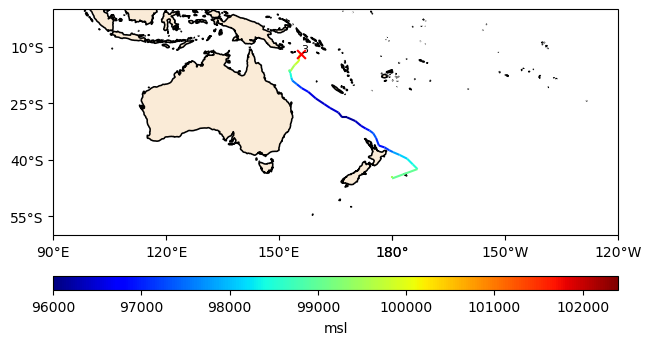

In [22]:
fig = plot_node_tracks(df_track,'msl', 960_00, 1024_00, 90, 240, -60, 0, 'jet')

<span style="color: mediumblue;">MSLP field</span>

In [23]:
idx_minmsl = df_track['msl'].idxmin()

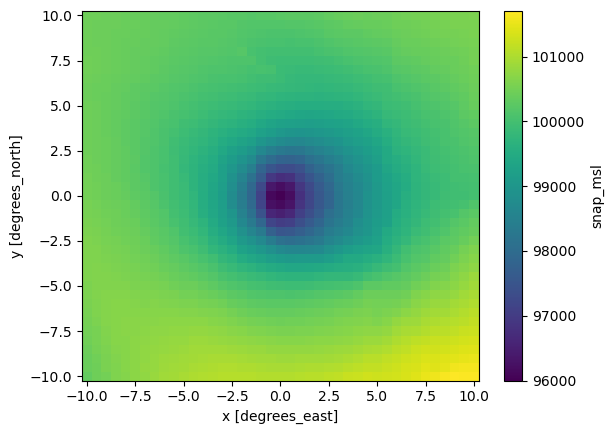

In [24]:
ds_track['snap_msl'].sel(snapshot=idx_minmsl).plot()